### Librerías usadas Python

Se importan las principales librerías utilizadas en el análisis y preprocesamiento:

- `pandas`: para la manipulación de datos tabulares.
- `numpy`: para operaciones numéricas.
- `matplotlib.pyplot`: para visualización básica.
- `seaborn`: para visualizaciones estadísticas más estilizadas.
- `re`: para trabajar con expresiones regulares.
- `scipy.stats.ttest_ind`: para realizar pruebas t de comparación de medias.
- `scipy.stats.chi2_contingency`: para pruebas de independencia entre variables categóricas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

## Visualizacion inicial datos

Cargamos el dataset en excel utilizando `pandas` para hacer el EDA y hacemos una vista general.

In [2]:
df = pd.read_excel('data.xlsx')
print(df.head(3).T.to_markdown(index=True))

|                           | 0             | 1             | 2                                                  |
|:--------------------------|:--------------|:--------------|:---------------------------------------------------|
| ID                        | 0             | 1             | 2                                                  |
| Patient Age               | 69            | 57            | 42                                                 |
| Patient Sex               | Female        | Male          | Male                                               |
| Left-Fundus               | 0_left.jpg    | 1_left.jpg    | 2_left.jpg                                         |
| Right-Fundus              | 0_right.jpg   | 1_right.jpg   | 2_right.jpg                                        |
| Left-Diagnostic Keywords  | cataract      | normal fundus | laser spot，moderate non proliferative retinopathy |
| Right-Diagnostic Keywords | normal fundus | normal fundus | moderate non prolif

### Descripción del conjunto de datos  
- **Filas (pacientes):** 3 500  
- **Columnas:** 15  
  - Información demográfica: `ID`, `Patient Age`, `Patient Sex`  
  - Rutas de imagen: `Left-Fundus`, `Right-Fundus`  
  - Observaciones clínicas: `Left-Diagnostic Keywords`, `Right-Diagnostic Keywords`  
  - Etiquetas binarias: `N`, `D`, `G`, `C`, `A`, `H`, `M`, `O` 
    

Se comprueba no hay ningún valor NA en el conjunto de datos y el tipo de datos en cada columna.

In [3]:
print(f"| Columna | Num NA | Tipo dato|")
print(f"|:-------|:----------|:-------|")
for feature in df.columns:
    type_data = str(type(df[feature][0])).split(' ')[1].replace('\'','').replace('>','')
    print(f"| {feature} |{sum(df[feature].isna())} | {type_data}|")

| Columna | Num NA | Tipo dato|
|:-------|:----------|:-------|
| ID |0 | numpy.int64|
| Patient Age |0 | numpy.int64|
| Patient Sex |0 | str|
| Left-Fundus |0 | str|
| Right-Fundus |0 | str|
| Left-Diagnostic Keywords |0 | str|
| Right-Diagnostic Keywords |0 | str|
| N |0 | numpy.int64|
| D |0 | numpy.int64|
| G |0 | numpy.int64|
| C |0 | numpy.int64|
| A |0 | numpy.int64|
| H |0 | numpy.int64|
| M |0 | numpy.int64|
| O |0 | numpy.int64|


Se comprueba que no hay entradas duplicadas verificando el conjunto total de las entradas y que no hay términos repetidos en la columna ID.

In [4]:
#print(f'Número de filas duplicadas: {df.duplicated().sum()}')  # Verificar si hay filas duplicadas 

In [5]:
#print(f'Número de IDs duplicados: {df.ID.duplicated().sum()}')  # Verificar si hay IDs duplicados

### Análisis de la variable 'Patient Age'

Se analiza la distribución de los pacientes por edades y se observa que los valores presentan una distribución unimodal ligeramente sesgada a la izquierda.

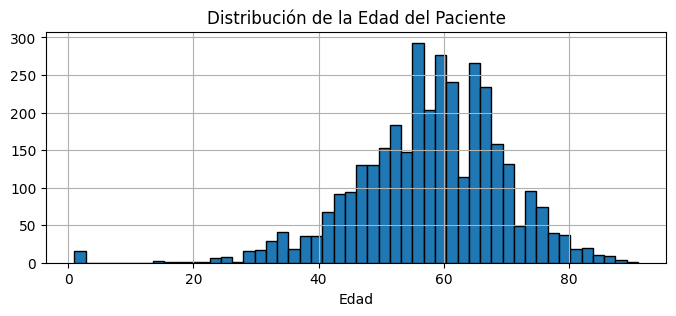

In [6]:
plt.figure(figsize=(8, 3))
df["Patient Age"].hist(bins=50, edgecolor='black')
plt.title('Distribución de la Edad del Paciente')
plt.xlabel('Edad')
plt.show()

| Métrica | Valor (años) |
|---------|:-------:|
| Min  | 1  |
| Max | 91 |
| Media | 57.8 |
| Mediana |  59 |
| Moda | 56 |

En los datos aparecen 16 pacientes con un año de edad, todas ellas niñas. Todos ellos presentan alguna patología que podría darse en niños.

In [7]:
#print(f'Número de pacientes con un año: {(df["Patient Age"] < 10).sum()}\n')
#df[df["Patient Age"] < 10].head(5)
disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

df['Disease'] = df[disease_cols].values.tolist()
df_sel = df[df['Patient Age'] < 10]
# Count occurrences of unique combinations in columns A, C, E
counts = df_sel.groupby(['Left-Diagnostic Keywords', 'Right-Diagnostic Keywords'] + disease_cols).size().reset_index(name='Conteo')
# Sort by count (descending)
counts_sorted = counts.sort_values('Conteo', ascending=False)
counts_sorted['Diseases'] = counts_sorted[disease_cols].values.tolist()
counts_sorted = counts_sorted.drop(disease_cols, axis=1)
counts_sorted = counts_sorted[['Left-Diagnostic Keywords', 'Right-Diagnostic Keywords','Diseases','Conteo']]
print(counts_sorted.to_markdown(index=False))
#df_sel = df_sel.drop(['Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus'] + disease_cols, axis = 1)
#print(df_sel.head(3).to_markdown(index=False))

| Left-Diagnostic Keywords                  | Right-Diagnostic Keywords            | Diseases                 |   Conteo |
|:------------------------------------------|:-------------------------------------|:-------------------------|---------:|
| pathological myopia                       | pathological myopia                  | [0, 0, 0, 0, 0, 0, 1, 0] |       11 |
| chorioretinal atrophy                     | normal fundus                        | [0, 0, 0, 0, 0, 0, 0, 1] |        1 |
| dry age-related macular degeneration      | dry age-related macular degeneration | [0, 0, 0, 0, 1, 0, 0, 0] |        1 |
| lens dust，normal fundus                  | lens dust，normal fundus             | [1, 0, 0, 0, 0, 0, 0, 0] |        1 |
| normal fundus                             | pathological myopia                  | [0, 0, 0, 0, 0, 0, 1, 0] |        1 |
| tessellated fundus，peripapillary atrophy | pathological myopia                  | [0, 0, 0, 0, 0, 0, 1, 1] |        1 |


El resto de pacientes presentan una edad superior o igual a 14 años.

In [8]:
#df[df["Patient Age"] > 1].sort_values(by="Patient Age", ascending=True).head()

### Análisis de la variable 'Patient Sex'

Se analiza la distribución de los pacientes según el sexo y se observa que el número de hombres (54%) es mayor que el de mujeres (46%)
  
| Sexo | Recuento | Porcentaje |
|------|----------|------------|
| Femenino | 1 620 | 46 % |
| Masculino | 1 880 | 54 % |
| **Total** | **3 500** | 100 % |

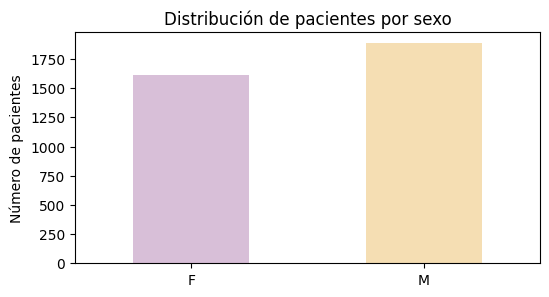

In [9]:
count = df['Patient Sex'].apply(lambda x: 'M' if x == 'Male' else 'F').value_counts().reindex(['F','M'])
plt.figure(figsize=(6, 3))
count.plot.bar(color = ['thistle', 'wheat'])
plt.title('Distribución de pacientes por sexo')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Número de pacientes')
plt.show()

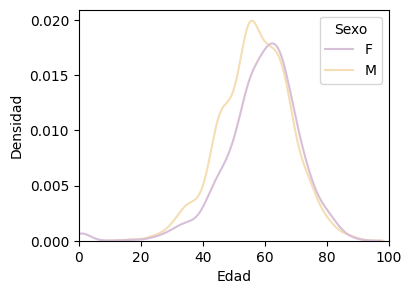

In [10]:
df['Sexo'] = df['Patient Sex'].apply(lambda x: 'M' if x == 'Male' else 'F')
plt.figure(figsize=(4, 3))
sns.kdeplot(x='Patient Age', hue = 'Sexo' ,fill=False, data=df, palette={'M': 'wheat', 'F': 'thistle'})
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.xlim(0,100)
plt.show()

### Análisis de las variables 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'

En los datos aparecen ocho columnas en las que se anota las enfermedades detectadas en cada paciente. A continuación se realiza una descripción de cada anotación.

|  | Enfermedad (ES / EN)                                                              | Descripción corta                                                                                                                             |
| -------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| **N**    | Normal                                                                            | Fondo de ojo sin hallazgos patológicos: vasos, mácula y nervio óptico se ven “de libro”.                                                      |
| **D**    | Retinopatía diabética / Diabetic Retinopathy                                      | Daño progresivo en los vasos de la retina por la diabetes; puede causar hemorragias, edema macular y pérdida de visión.                       |
| **G**    | Glaucoma                                                                          | Lesión del nervio óptico (normalmente por presión intraocular alta); afecta primero la visión periférica y, sin tratamiento, lleva a ceguera. |
| **C**    | Catarata / Cataract                                                               | Opacidad del cristalino que nubla la visión; causa prevenible de ceguera, se soluciona con cirugía de reemplazo de lente.                     |
| **A**    | Degeneración macular asociada a la edad (DMAE) / Age-related Macular Degeneration | Deterioro de la mácula que borra la visión central (leer, reconocer caras).                                                                   |
| **H**    | Retinopatía hipertensiva / Hypertensive Retinopathy                               | Lesiones en los vasos retinianos por hipertensión crónica; provoca hemorragias, exudados y visión borrosa.                                    |
| **M**    | Miopía patológica / Pathologic Myopia                                             | Miopía muy alta que adelgaza y estira la retina, aumentando riesgo de desprendimiento y otras complicaciones.                                 |
| **O**    | Otras anomalías / Other Abnormalities                                             | Cajón de sastre: cualquier hallazgo que no encaje en las categorías anteriores (p. ej. oclusión arterial, membrana epirretiniana).            |


Se analiza la distribución de pacientes por enfermedades y se observa que la anotación más común es el estado normal (N), presente en un 33% de los pacientes. La enfermedad anotada más común es la retinopatía diabética (D), que aparece en un 32% de los pacientes. El resto de enfermedades anotadas se presentan de forma minoritaria con un porcentaje inferior al 7%. La anotación 'Other Abnormalities' aparece en el 28% de los pacientes.

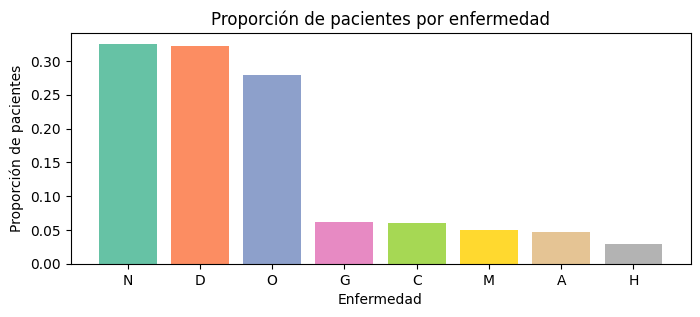

In [11]:
disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

disease_counts = df[disease_cols].sum().sort_values(ascending=False)/df.shape[0]
plt.figure(figsize=(8, 3))
set2_colors = plt.cm.Set2.colors
plt.bar(disease_counts.index, disease_counts.values, color = set2_colors)
plt.title('Proporción de pacientes por enfermedad')
plt.xlabel('Enfermedad')
plt.ylabel('Proporción de pacientes')
plt.show()

####  Distribución de pacientes por sexo y enfermedad

Se observa la distribución que presentan los pacientes según el sexo en las diferentes enfermedades. Se divide el número de pacientes por sexo y enfermedad por el número de casos en cada enfermedad. En la representación de estas proporciones se observa que el género masculino tiene mayor representación en la condición normal y en la mayoría de las enfermedades. Sólo en las anotaciones de catarátas (C) y miopía patológica (M) tienen mayor representación las mujeres. A la hora de valorar estos resultados hay que tener en cuenta que de partida el número de pacientes de genero masculino es mayor.

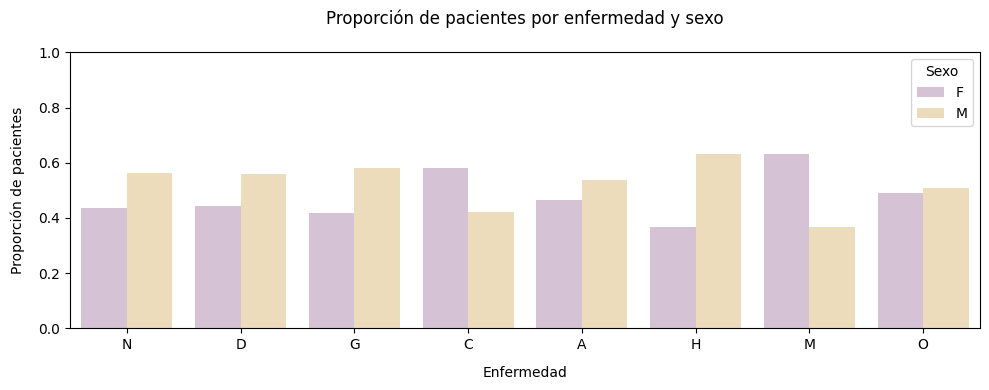

In [12]:
disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
# Numero de pacientes para cada enfermedad
disease_counts = df[disease_cols].sum()
# Numero de pacientes para cada sexo por enfermedad
df_sex_disease_num = df.groupby('Patient Sex')[disease_cols].sum()
# Proporción de pacientes para cada sexo por enfermedad
df_sex_disease_prop = df_sex_disease_num/disease_counts
# Reorganización para plotear
df_sex_disease_prop = df_sex_disease_prop.reset_index()
df_melted = pd.melt(df_sex_disease_prop,
        id_vars = ['Patient Sex'],          # Keep sex column as identifier
        value_vars = disease_cols,  # Columns to melt
        var_name = 'Disease',    # Name for the new variable column
        value_name='Prop Patients'        # Name for the value column
)
df_melted['Patient Sex'] = df_melted['Patient Sex'].apply(lambda x: 'M' if x == 'Male' else 'F')
# bar plot
plt.figure(figsize=(10, 4))
sns.barplot(
    x='Disease', 
    y='Prop Patients', 
    hue='Patient Sex',
    data=df_melted,
    palette={'M': 'wheat', 'F': 'thistle'},  # Custom colors
)
plt.title('Proporción de pacientes por enfermedad y sexo', pad=20)
plt.xlabel('Enfermedad', labelpad=10)
plt.ylabel('Proporción de pacientes', labelpad=10)
plt.legend(title='Sexo')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()
    

#### Test de independencia entre sexo del paciente y presencia de enfermedad

- Definimos una lista de enfermedades (sin incluir `'N'` ya que nos indica que es normal).
- Para cada enfermedad:
  - Construimos una tabla de contingencia cruzando `Patient Sex` con la presencia (1) o ausencia (0) de la enfermedad.
  - Calculamos la tabla de proporciones dividiendo por el total de pacientes por sexo (variable `patient_sex`).
  - Ejecutamos la prueba chi-cuadrado de independencia (`chi2_contingency`) para evaluar si la distribución del sexo es independiente de la presencia de la enfermedad.

In [13]:
# Enfermedades sin 'N'
diseases = ['D', 'G', 'C', 'A', 'H', 'M', 'O']

sex_results = []

for disease in diseases:
    contingency_table = pd.crosstab(df['Patient Sex'], df[disease])
    #df_porc = contingency_table.div(patient_sex, axis = 0)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    sign = ''
    if p < 0.001:
        sign = '***'
    elif p < 0.01:
        sign = '**'
    elif p < 0.05:
        sign = '*'
    sex_results.append({'Enfermedad': disease, 'p-valor': p, 'Significancia':sign})
#    print(contingency_table)

#pd.DataFrame(sex_results)
df_results = pd.DataFrame(sex_results)
df_results['p-valor'] = df_results['p-valor'].apply(lambda x: float(f"{x:.2g}"))
print(df_results.to_markdown(index=False))

| Enfermedad   |   p-valor | Significancia   |
|:-------------|----------:|:----------------|
| D            |   0.11    |                 |
| G            |   0.22    |                 |
| C            |   0.00045 | ***             |
| A            |   1       |                 |
| H            |   0.07    |                 |
| M            |   5.2e-06 | ***             |
| O            |   0.036   | *               |


| Símbolo | p-valor       | ¿Significativo?    |
|:---------:|------------------|-----------------------------------|
|  ***    | p $<$ 0.001    | Muy altamente significativo   | 
|  **     | 0.001 $\leq$ p $<$ 0.01 | Altamente significativo    | 
|  *      | 0.01 $\leq$ p $<$ 0.05 | Estadísticamente significativo |
|         | p $\geq$ 0.05     | No estadísticamente significativo | 

**Interpretación:**

- Un p-valor menor a 0.05 indica que la distribución del sexo está significativamente asociada con la presencia de la enfermedad.
- En este caso, las enfermedades de cataratas (C) y miopía patológica (M), así como la presencia de otras enfermedades (O) muestran una asociación significativa con el sexo del paciente, siendo más común este tipo de enfermedades en el grupo de mujeres que en el de hombres.
- Para las demás enfermedades, no se detecta asociación significativa.

Estos resultados se han obtenido a partir de un conjunto de datos preparado para otro propósito diferente al de valorar la prevalencia de las enfermedades en los diferentes sexos. Al considerar que esta muestra de pacientes no se ha extraido de forma aleatoria sino haciendo una selección de los mismos, los resultados obtenidos no son extrapolables a la población general.

#### Distribución de edades de los pacientes para cada enfermedad

Se analiza la distribución de las edades de los pacientes para cada enfermedad anotada. Para todas las enfermedades las edades siguen una distribución normal y se extienden dentro del mismo rango. Aquí también se observa como algunas enfermedades presentan casos a edades muy tempranos como vimos anteriormente. Las cataratas (C), la miopía patológica (M) y el glaucoma (G) tienden a aparecer a edades más tardías, mientras que los pacientes que aparecen anotadas como normales (N) y aquellos que sufren de retinopatía diabética (D) presentan distribuciones centradas en edades inferiores al resto de enfermedades.

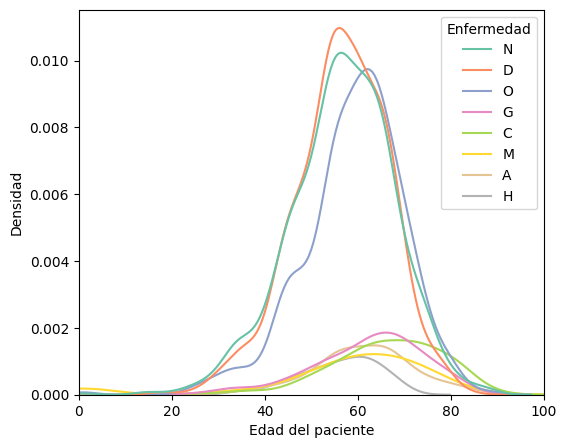

In [14]:
disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

disease_order = list(df[disease_cols].sum().sort_values(ascending=False).index)
list_df = []
for d in disease_order:
    list_df.append(pd.DataFrame({'Patient Age':df[df[d] == 1]['Patient Age'],'Disease': d}))

df_concat = pd.concat(list_df, axis=0)
df_concat['Enfermedad'] = df_concat['Disease']

plt.figure(figsize=(6, 5))
set2_colors = plt.cm.Set2.colors
sns.kdeplot(x='Patient Age', hue = 'Enfermedad' ,fill=False, data=df_concat, palette = "Set2")
plt.xlabel('Edad del paciente')
plt.ylabel('Densidad')
plt.xlim(0,100)
plt.show()


#### Distribución del número de enfermedades por paciente

Se analiza como se distribuyen los pacientes según el número de enfermedades que le han sido diagnosticadas. Los pacientes que no presentan ninguna enfermedad son aquellos que han sido anotados con valor '1' en la columna 'N' y representan, como ya se comprobó, el 33% de los pacientes. La mayoría de los pacientes con alguna enfermedad anotada presentan una única enfermedad (51%). El 16% de los pacientes presentan dos enfermedades anotadas y un pequeño número de pacientes, menos del 1%, presentan tres enfermedades. No aparecen pacientes con más de tres enfermedades anotadas.

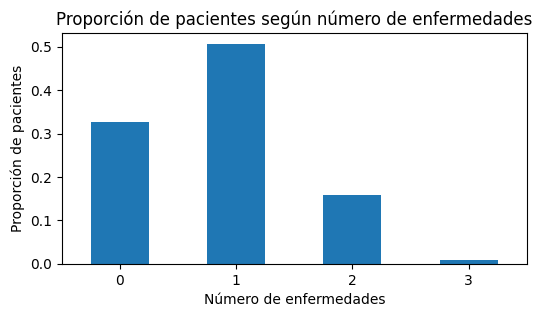

In [15]:
disease_cols = ['D', 'G', 'C', 'A', 'H', 'M', 'O']

count_disease_patient = df[disease_cols].sum(axis=1).value_counts()
prop_disease_patient = (count_disease_patient/df.shape[0]).reindex([0,1,2,3])
plt.figure(figsize=(6, 3))
prop_disease_patient.plot.bar()
plt.title('Proporción de pacientes según número de enfermedades')
plt.xlabel('Número de enfermedades')
plt.xticks(rotation=0)
plt.ylabel('Proporción de pacientes')
plt.show()

### Análisis de las variables 'Left-Diagnostic Keywords' y 'Right-Diagnostic Keywords'

En los datos hay dos columnas en las que se describen los diagnósticos en cada ojo. Se trataría de una descripción más detallada de lo que posteriormente se refleja en las columnas de enfermedades. En algunos casos las anotaciones no tienen que ver con el diagnóstico sino con incidencias en las imágenes.

En las columnas aparecen un total de 102 diagnósticos únicos, siendo el más común 'normal fundus'. Entre los diagnósticos más comunes aparece también 'lens dust' que hace referencia a un artefacto un las imágenes.

In [16]:
def contar_diagnosticos(df, columnas):
    """
    Devuelve los diagnósticos únicos en las columnas indicadas 
    y el número de veces que aparecen los diagnósticos
    """
    # Patrón que contempla:
    #   ,  -> coma ASCII
    #   ， -> coma china U+FF0C
    #   ;  -> punto y coma (opcional, por si acaso)
    separadores = r'[,\uFF0C;]\s*'
    s = (
        df[columnas]
          .stack()            # junta las columnas en un único Series
          .astype(str)        # asegura que todo es string
          .str.split(separadores, regex=True, expand=False)  # <-- AQUÍ EL CAMBIO
          .explode()          # cada elemento en su propia fila
          .str.strip()        # quita espacios al inicio/fin
          .str.lower()        # homogeneiza mayúsculas/minúsculas
    )

    s = s[s != '']            # elimina cadenas vacías
    recuento = s.value_counts()
    return recuento
    
cols = ["Left-Diagnostic Keywords", "Right-Diagnostic Keywords"]
conteo_diagn = contar_diagnosticos(df, cols)
conteo_diagn = conteo_diagn.rename('Conteo')
#conteo_diagn['Conteo'] = conteo_diagn['count']
#conteo_diagn = conteo_diagn.drop(['count'], axis=1)
#print(f"Número total de diagnósticos distintos: {conteo_diagn.size}\n")
#print('Top 10 diagnósticos más frequentes:')
#print('-----------------------------------')
#print(conteo_diagn.head(10))
print('Top 5 diagnósticos más frequentes:\n')
print(conteo_diagn.head(5).to_markdown(index=True))

Top 5 diagnósticos más frequentes:

|                                        |   Conteo |
|:---------------------------------------|---------:|
| normal fundus                          |     3100 |
| moderate non proliferative retinopathy |      997 |
| mild nonproliferative retinopathy      |      552 |
| lens dust                              |      408 |
| cataract                               |      313 |


La mayor parte de los diagnósticos aparecen muy pocas veces, por ejemplo, el 80% de los diagnósticos aparece en menos de 40 imágenes de un total de 7000.

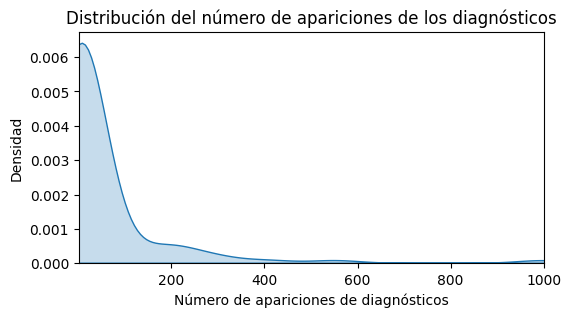

In [17]:
#print(f'Porcentaje de diagnósticos que aparecen menos de 40 veces: {sum(conteo_diagn < 40)/conteo_diagn.size*100:.1f}%')
plt.figure(figsize=(6, 3))
sns.kdeplot(fill=True, data=conteo_diagn[conteo_diagn < 1000])
plt.xlim(1,1000)
plt.title('Distribución del número de apariciones de los diagnósticos')
plt.xlabel('Número de apariciones de diagnósticos')
plt.xticks(rotation=0)
plt.ylabel('Densidad')
plt.show()

Se comprueba que la anotación de la columna 'N' y los diagnósticos concuerdan, de forma que no haya ningún diagnóstico de enfermedad en un paciente que esté anotado como normal ('N' con valor 1)

Además del diagnóstico 'normal fundus' aparecen dos diagnósticos más relacionadas con artefactos en las imágenes, 'lens dust' y 'low image quality'.

In [18]:
cols = ["Left-Diagnostic Keywords", "Right-Diagnostic Keywords"]
conteo_diagn = contar_diagnosticos(df[df['N'] == 1], cols)
conteo_diagn = conteo_diagn.rename('Conteo')
print(conteo_diagn.to_markdown(index=True))

|                   |   Conteo |
|:------------------|---------:|
| normal fundus     |     2277 |
| lens dust         |      222 |
| low image quality |        3 |


Se buscan diagnósticos que tengan que ver con artefactos en las imágenes buscando las palabras claves 'image' y 'lens' en los diagnósticos. Se encuentran cinco términos que pudieran estar relacionados incidencias técnicas en las imágenes.

In [19]:
cols = ["Left-Diagnostic Keywords", "Right-Diagnostic Keywords"]
conteo_diagn = contar_diagnosticos(df, cols)
conteo_diagn.index

words_to_find = ["lens", "image"]
diagnostics_index = conteo_diagn.index
mask = diagnostics_index.str.contains('|'.join(words_to_find), case=False, na=False)
conteo_diagn = conteo_diagn.rename('Conteo')
print(conteo_diagn[mask].to_markdown(index=True))

|                        |   Conteo |
|:-----------------------|---------:|
| lens dust              |      408 |
| low image quality      |       21 |
| anterior segment image |        2 |
| image offset           |        1 |
| no fundus image        |        1 |


In [20]:
#diagnostic = 'lens dust'
#df[df['Left-Diagnostic Keywords'].str.contains(diagnostic) | df['Right-Diagnostic Keywords'].str.contains(diagnostic)].head(3)

In [21]:
#diagnostic = 'low image quality'
#df[df['Left-Diagnostic Keywords'].str.contains(diagnostic) | df['Right-Diagnostic Keywords'].str.contains(diagnostic)].head(5)

In [22]:
#diagnostics = ['anterior segment image', 'image offset', 'no fundus image']
#regex = '|'.join(diagnostics)
#df[df['Left-Diagnostic Keywords'].str.contains(regex) | df['Right-Diagnostic Keywords'].str.contains(regex)]